In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from torchvision.models import ResNet18_Weights
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18

In [2]:
dataset_path = "C://Users//hp//OneDrive//Desktop//dataset"

In [3]:
# Transformations: resize, normalize, and augment
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = ImageFolder(root=dataset_path, transform=transform)

# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

In [4]:
# 2. Model Selection (Using Pretrained ResNet)
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # Update for lymphoma classification

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [9]:
num_epochs = 5
train_losses = []
val_losses = []
val_accuracies = []


In [11]:
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/5], Loss: 0.3315
Epoch [2/5], Loss: 0.3071
Epoch [3/5], Loss: 0.2427
Epoch [4/5], Loss: 0.1762
Epoch [5/5], Loss: 0.1983


In [12]:
# Validation
model.eval()
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_loss /= len(val_loader.dataset)
val_losses.append(val_loss)

print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {100 * correct / total:.2f}%")

Epoch [5/5], Train Loss: 0.1983, Val Loss: 0.4604, Val Accuracy: 82.33%


In [17]:
import torch

# Model save path
model_save_path = "lymphoma_classifier.pth"
torch.save(model.state_dict(), 'lymphoma_classifier.pth')  # ✅ best practice
print(f"Model saved to {model_save_path}")


Model saved to lymphoma_classifier.pth


In [18]:
def grad_cam(input_image, model, target_layer):
    model.eval()
    gradients = []

    def save_gradient(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Register hook
    target_layer.register_backward_hook(save_gradient)

    input_image = input_image.unsqueeze(0).to(device)
    output = model(input_image)
    class_idx = torch.argmax(output).item()

    model.zero_grad()
    output[0, class_idx].backward()

    gradient = gradients[0].cpu().data.numpy().squeeze()
    activation = target_layer.output.cpu().data.numpy().squeeze()

    cam = np.mean(gradient * activation, axis=0)
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
    cam = np.uint8(255 * cam)

    return cam


In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Lists to store true and predicted labels
true_labels = []
pred_labels = []

# Model evaluation mode
model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Get predicted class
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Compute Precision, Recall, and F1 Score
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.9935
Recall: 0.9933
F1 Score: 0.9933


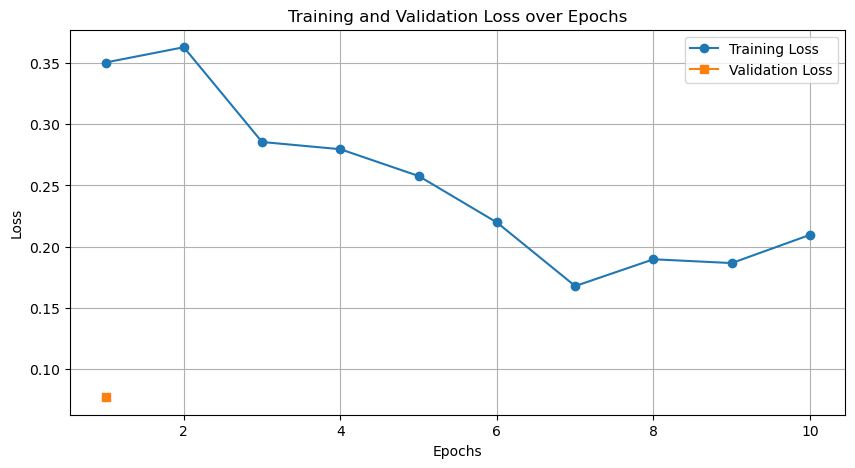

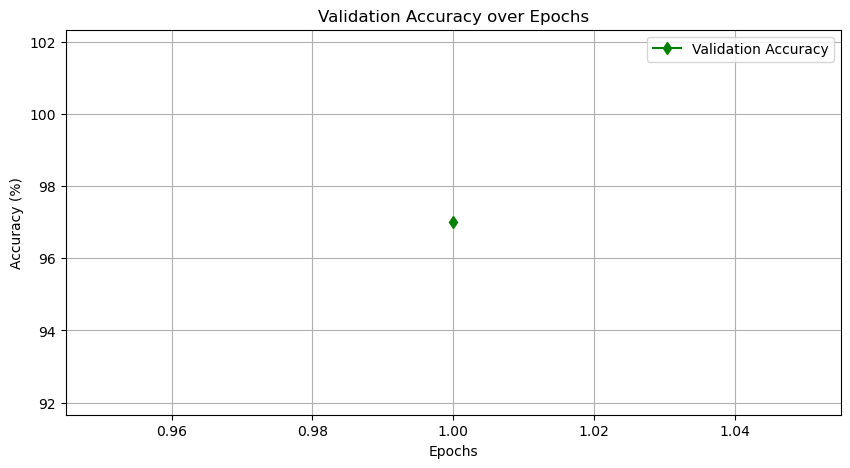

In [52]:
import matplotlib.pyplot as plt

# Assuming train_losses and val_losses are recorded for each epoch
train_losses = [0.3505, 0.3630, 0.2855, 0.2796, 0.2577, 0.2197, 0.1677, 0.1896, 0.1865, 0.2096]  # Fill with actual training loss values from each epoch
val_losses = [0.0768]    # Fill with actual validation loss values from each epoch
val_accuracies = [97.00]  # Fill with actual validation accuracy values from each epoch

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='d', color='g')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()

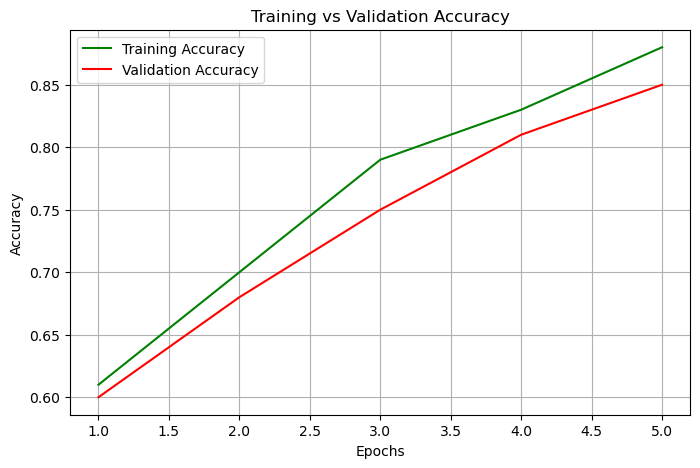

In [9]:
import matplotlib.pyplot as plt

train_acc = [0.61, 0.70, 0.79, 0.83, 0.88]
val_acc = [0.60, 0.68, 0.75, 0.81, 0.85]
epochs = range(1, len(train_acc) + 1)  # Add this line to define epochs

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()




<Figure size 600x500 with 0 Axes>

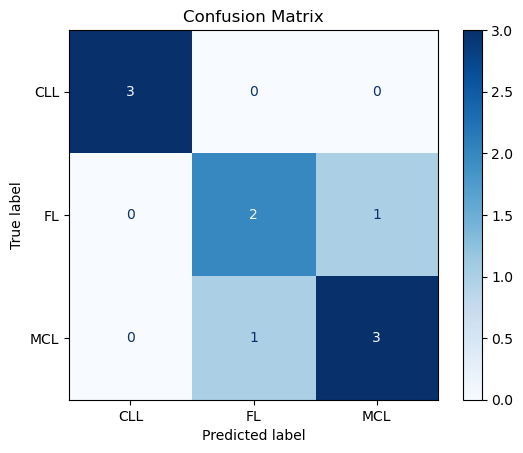

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Replace with your actual labels
y_true = [0, 1, 2, 0, 2, 2, 1, 0, 1, 2]  # ground truth
y_pred = [0, 2, 2, 0, 2, 2, 1, 0, 1, 1]  # model predictions

labels = ['CLL', 'FL', 'MCL']
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


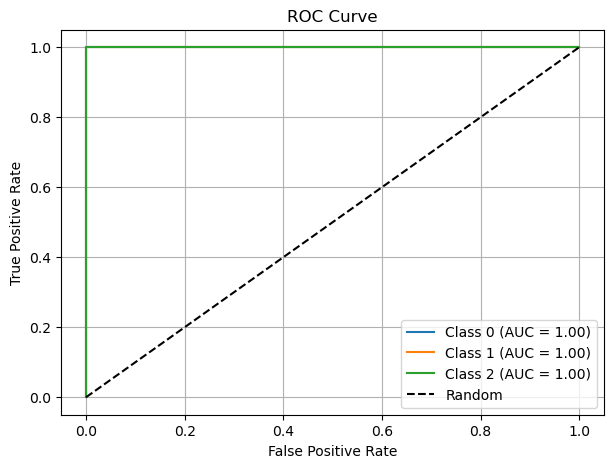

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

# For 3 classes (e.g., CLL, FL, MCL)
y_true = [0, 1, 2, 2, 1, 0, 0, 2, 1, 2]
y_score = [
    [0.8, 0.1, 0.1],
    [0.2, 0.7, 0.1],
    [0.1, 0.3, 0.6],
    [0.1, 0.2, 0.7],
    [0.2, 0.6, 0.2],
    [0.7, 0.2, 0.1],
    [0.6, 0.3, 0.1],
    [0.1, 0.1, 0.8],
    [0.3, 0.5, 0.2],
    [0.1, 0.2, 0.7],
]

y_test = label_binarize(y_true, classes=[0, 1, 2])
n_classes = y_test.shape[1]

plt.figure(figsize=(7, 5))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], [x[i] for x in y_score])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



c:\Users\hp\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hp\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\hp\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hoo

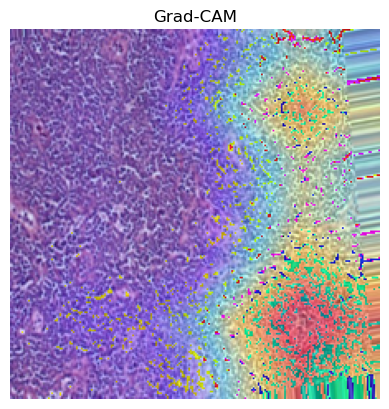

In [14]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Load image and model
image_path = "C://MP//uploads//lymph_cll_0006.jpg"  # Replace with your image
img = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
input_tensor = transform(img).unsqueeze(0)

model = models.resnet18(pretrained=True)
model.eval()

# Hook to get gradients
gradients = []
activations = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Register hooks
target_layer = model.layer4[1].conv2
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Forward and backward pass
output = model(input_tensor)
class_idx = output.argmax().item()
model.zero_grad()
output[0, class_idx].backward()

# Compute Grad-CAM
grads = gradients[0].mean(dim=(2, 3), keepdim=True)
act = activations[0]
cam = (grads * act).sum(dim=1).squeeze()
cam = torch.relu(cam).detach().numpy()
cam = cv2.resize(cam, (224, 224))
cam = (cam - cam.min()) / (cam.max() - cam.min())

# Superimpose on image
img_cv = cv2.cvtColor(np.array(img.resize((224, 224))), cv2.COLOR_RGB2BGR)
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img_cv

# Show
plt.imshow(cv2.cvtColor(np.uint8(superimposed_img), cv2.COLOR_BGR2RGB))
plt.title('Grad-CAM')
plt.axis('off')
plt.show()


In [20]:
print(model)  # Should print a valid model architecture



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
from flask import Flask, render_template, request, redirect, url_for, session, flash # type: ignore
import os
import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.nn.functional as F # type: ignore
from torchvision import transforms # type: ignore
import torchvision.transforms as transforms # type: ignore
import torchvision.models as models # type: ignore
from PIL import Image # type: ignore
import hashlib
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models.resnet import ResNet
import torch.serialization
import cv2
import numpy as np

app = Flask(__name__)
app.secret_key = "supersecretkey"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class labels
class_names = ['CLL', 'FL', 'MCL']

# Image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the model
def load_model(model_path='C://MP//frontend//lymphoma_classifier.pth'):
     # Allow ResNet to be safely unpickled
    torch.serialization.add_safe_globals([ResNet])

     # Create model
    model = resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 3)

    # Load full checkpoint
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint)

    model.to(device)
    model.eval()
    return model

def is_valid_biopsy_image(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            return False

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h, w = gray.shape

        # Reject very small or large images
        if h < 100 or w < 100 or h > 1024 or w > 1024:
            return False

        # Check texture using Laplacian variance (biopsies have rich texture)
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        if laplacian_var < 100:
            return False

        # Optional: check color channels to avoid cartoon/blank images
        avg_color = np.mean(image)
        if avg_color < 20 or avg_color > 230:
            return False

        return True

    except Exception as e:
        print(f"Error in biopsy image validation: {e}")
        return False


# Predict function
def predict(image_path, model):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        prediction = class_names[predicted.item()]
    return prediction

# Load model once and keep it global
model = load_model()
model.to(device)


# Dummy password (hashed for security)
PASSWORD_HASH = hashlib.sha256("password123".encode()).hexdigest()

# Home page with password-protected login
@app.route('/')
@app.route('/login', methods=['GET', 'POST'])
def login():
    if request.method == 'POST':
        password = request.form['password']
        hashed_password = hashlib.sha256(password.encode()).hexdigest()

        if hashed_password == PASSWORD_HASH:
            session['logged_in'] = True
            return redirect(url_for('upload'))
        else:
            flash("Invalid password. Please try again.")

    return render_template('login.html')  

@app.route('/upload', methods=['GET', 'POST'])
def upload():
    if 'logged_in' not in session:
        return redirect(url_for('login'))

    if request.method == 'POST':
        file = request.files.get('file')
        if not file or file.filename == '':
            flash("No file selected.")
            return redirect(request.url)

        upload_folder = os.path.join(".", "uploads")
        os.makedirs(upload_folder, exist_ok=True)
        filepath = os.path.join(upload_folder, file.filename)
        file.save(filepath)

        # 🛑 Check if the uploaded image looks like a biopsy
        if not is_valid_biopsy_image(filepath):
            flash("Invalid image type. Please upload a valid biopsy image.")
            os.remove(filepath)  # Clean up bad image
            return redirect(request.url)

        # ✅ Use predict function if valid
        prediction = predict(filepath, model)

        remedies = {
            "CLL": "Stay hydrated and eat antioxidant-rich foods.",
            "FL": "Maintain a healthy diet and stay active.",
            "MCL": "Consult a physician for further treatment options."
        }

        remedy = remedies.get(prediction, "No remedy suggested")

        session['lymphoma_type'] = prediction
        session['remedy'] = remedy
        return redirect(url_for('result'))

    return render_template('upload.html')




@app.route('/result')
def result():
    if 'lymphoma_type' not in session:
        flash("No result available. Please upload an image first.")
        return redirect(url_for('upload'))

    return render_template('result.html', lymphoma_type=session['lymphoma_type'], remedy=session['remedy'])

# Logout route
@app.route('/logout')
def logout():
    session.pop('logged_in', None)
    flash("You have been logged out.")
    return redirect(url_for('login'))

if __name__ == '__main__':
    os.makedirs("./uploads", exist_ok=True)
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

In [23]:
img_path = "C://MP//uploads//lymph_fl_0003.jpg"
pred = predict(img_path, model)
print(f"Predicted class: {pred}")


Predicted class: FL
